In [1]:
import kagglehub
from pathlib import Path
import numpy as np
from PIL import Image


path = kagglehub.dataset_download("hamzamohiuddin/isbi-2012-challenge")

print("Path to dataset files:", path)

root = Path(path) / "unmodified-data"

train_imgs_dir = root / "train" / "imgs"
train_lbls_dir = root / "train" / "labels"

test_imgs_dir  = root / "test" / "imgs"
test_lbls_dir  = root / "test" / "labels"


def load_png_folder(img_dir, lbl_dir):
    img_files = sorted(img_dir.glob("*.png"))
    lbl_files = sorted(lbl_dir.glob("*.png"))

    assert len(img_files) == len(lbl_files)

    X, y = [], []

    for img_f, lbl_f in zip(img_files, lbl_files):
        X.append(np.array(Image.open(img_f).convert("L")))
        y.append(np.array(Image.open(lbl_f)))

    X = np.stack(X)  # (N, H, W)
    y = np.stack(y)

    return X, y


X_train, y_train = load_png_folder(train_imgs_dir, train_lbls_dir)
X_test,  y_test  = load_png_folder(test_imgs_dir,  test_lbls_dir)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Using Colab cache for faster access to the 'isbi-2012-challenge' dataset.
Path to dataset files: /kaggle/input/isbi-2012-challenge
(30, 512, 512) (30, 512, 512)
(30, 512, 512) (30, 512, 512)


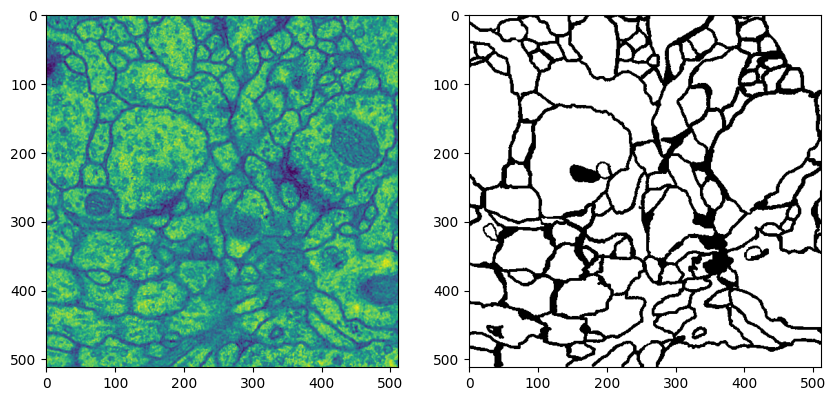

In [2]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(X_train[0])
axes[1].imshow(y_train[0],cmap='gray')

plt.show()

In [3]:
import torch

X_train,y_train = torch.tensor(X_train),torch.tensor(y_train)
X_test,y_test = torch.tensor(X_test),torch.tensor(y_test)

X_train,y_train = X_train / 255, y_train / 255
X_test,y_test = X_test / 255, y_test / 255

X_train,y_train = X_train.unsqueeze(1), y_train.unsqueeze(1)
X_test,y_test = X_test.unsqueeze(1), y_test.unsqueeze(1)

In [4]:
def augment_data(X, y):
    xs, ys = [], []
    for i in range(len(X)):
        img, mask = X[i], y[i]
        for k in range(4):
            rot_img = torch.rot90(img, k, [-2, -1])
            rot_mask = torch.rot90(mask, k, [-2, -1])

            xs.append(rot_img)
            ys.append(rot_mask)

            xs.append(torch.flip(rot_img, [-1]))
            ys.append(torch.flip(rot_mask, [-1]))

    return torch.stack(xs), torch.stack(ys)

In [5]:
X_train_aug, y_train_aug = augment_data(X_train, y_train)
print(f"{X_train.shape[0]} to {X_train_aug.shape[0]}")

30 to 240


In [6]:
from torch.utils.data import TensorDataset, DataLoader, random_split
train_ds = TensorDataset(X_train_aug, y_train_aug)
test_ds = TensorDataset(X_test, y_test)

val_size = int(len(test_ds) * 0.2)
test_size = int(len(test_ds) * 0.8)

val_ds, final_test_ds = random_split(test_ds, [val_size, test_size])

In [7]:
print(f"train: {len(train_ds)}")
print(f"val: {len(val_ds)}")
print(f"test: {len(final_test_ds)}")

train: 240
val: 6
test: 24


In [8]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)
test_loader = DataLoader(final_test_ds, batch_size=1, shuffle=False)

In [9]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [10]:
class MiniUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(MiniUNet, self).__init__()

        base = 32

        self.down1 = DoubleConv(in_channels, base)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            DoubleConv(base*8, base*16),
            nn.Dropout2d(0.5)
        )

        self.up4 = nn.ConvTranspose2d(base*16, base*8, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(base*16, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(base*2, base)

        self.final_conv = nn.Conv2d(base, out_channels, kernel_size=1)

    def forward(self, x):

        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        c3 = self.down3(p2)
        p3 = self.pool3(c3)
        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        u4 = self.up_conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, c3], dim=1)
        u3 = self.up_conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, c2], dim=1)
        u2 = self.up_conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, c1], dim=1)
        u1 = self.up_conv1(u1)

        return self.final_conv(u1)

In [11]:
import torch.optim as optim

device = "cuda"
model = MiniUNet(in_channels=1, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [12]:
import torch.nn.functional as F

def dice_bce_loss(outputs, targets, smooth=1.0):
    bce = F.binary_cross_entropy_with_logits(outputs, targets)

    pred = torch.sigmoid(outputs)
    pred = pred.view(-1)
    target = targets.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return bce + (1.0 - dice)

In [13]:
epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = dice_bce_loss(outputs, masks)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = dice_bce_loss(outputs, masks)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    msg = "NEW BEST" if avg_val_loss < best_val_loss else ""
    if msg: best_val_loss = avg_val_loss; torch.save(model.state_dict(), 'best_model.pth')

    print(f"[{epoch+1}/{epochs}] train: {avg_train_loss:.4f} val: {avg_val_loss:.4f} {msg}")

[1/50] train: 1.2132 val: 1.1348 NEW BEST
[2/50] train: 0.9987 val: 0.9969 NEW BEST
[3/50] train: 0.8861 val: 0.8438 NEW BEST
[4/50] train: 0.8407 val: 0.8064 NEW BEST
[5/50] train: 0.8143 val: 0.7737 NEW BEST
[6/50] train: 0.7914 val: 0.7506 NEW BEST
[7/50] train: 0.7733 val: 0.7433 NEW BEST
[8/50] train: 0.7601 val: 0.7204 NEW BEST
[9/50] train: 0.7457 val: 0.7295 
[10/50] train: 0.7328 val: 0.7240 
[11/50] train: 0.7214 val: 0.7186 NEW BEST
[12/50] train: 0.7103 val: 0.7041 NEW BEST
[13/50] train: 0.7006 val: 0.6988 NEW BEST
[14/50] train: 0.6897 val: 0.7212 
[15/50] train: 0.6803 val: 0.7236 
[16/50] train: 0.6713 val: 0.6960 NEW BEST
[17/50] train: 0.6617 val: 0.6834 NEW BEST
[18/50] train: 0.6524 val: 0.6933 
[19/50] train: 0.6443 val: 0.6790 NEW BEST
[20/50] train: 0.6355 val: 0.7020 
[21/50] train: 0.6266 val: 0.6661 NEW BEST
[22/50] train: 0.6184 val: 0.6987 
[23/50] train: 0.6098 val: 0.6491 NEW BEST
[24/50] train: 0.6026 val: 0.6476 NEW BEST
[25/50] train: 0.5949 val: 0.6414

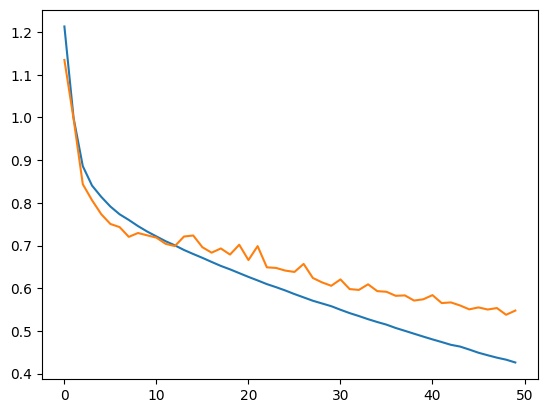

In [14]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [15]:
def calc_iou(model, loader, device, threshold=0.5):
    total_iou = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = (torch.sigmoid(model(images)) > threshold).float()

            preds = preds.view(preds.size(0), -1)
            masks = masks.view(masks.size(0), -1)

            intersection = (preds * masks).sum(dim=1)
            union = (preds + masks).clamp(0, 1).sum(dim=1)

            iou = (intersection + 1e-7) / (union + 1e-7).mean().item()
            total_iou += iou.mean().item()

    return total_iou / len(loader)


def find_best_threshold(model, loader, device):
    thresholds = np.linspace(0.1, 0.9, 17)
    best_iou = 0
    best_threshold = 0.5

    for t in thresholds:
        iou = calc_iou(model, loader, device,threshold = t)

        if iou > best_iou:
            best_iou = iou
            best_threshold = t

    return best_threshold.item()

In [16]:
best_t = find_best_threshold(model, val_loader, device)
print(f"Best Threshold: {best_t:.2f} | Test IoU: {calc_iou(model, test_loader, device,best_t):.4f}")

Best Threshold: 0.55 | Test IoU: 0.8729


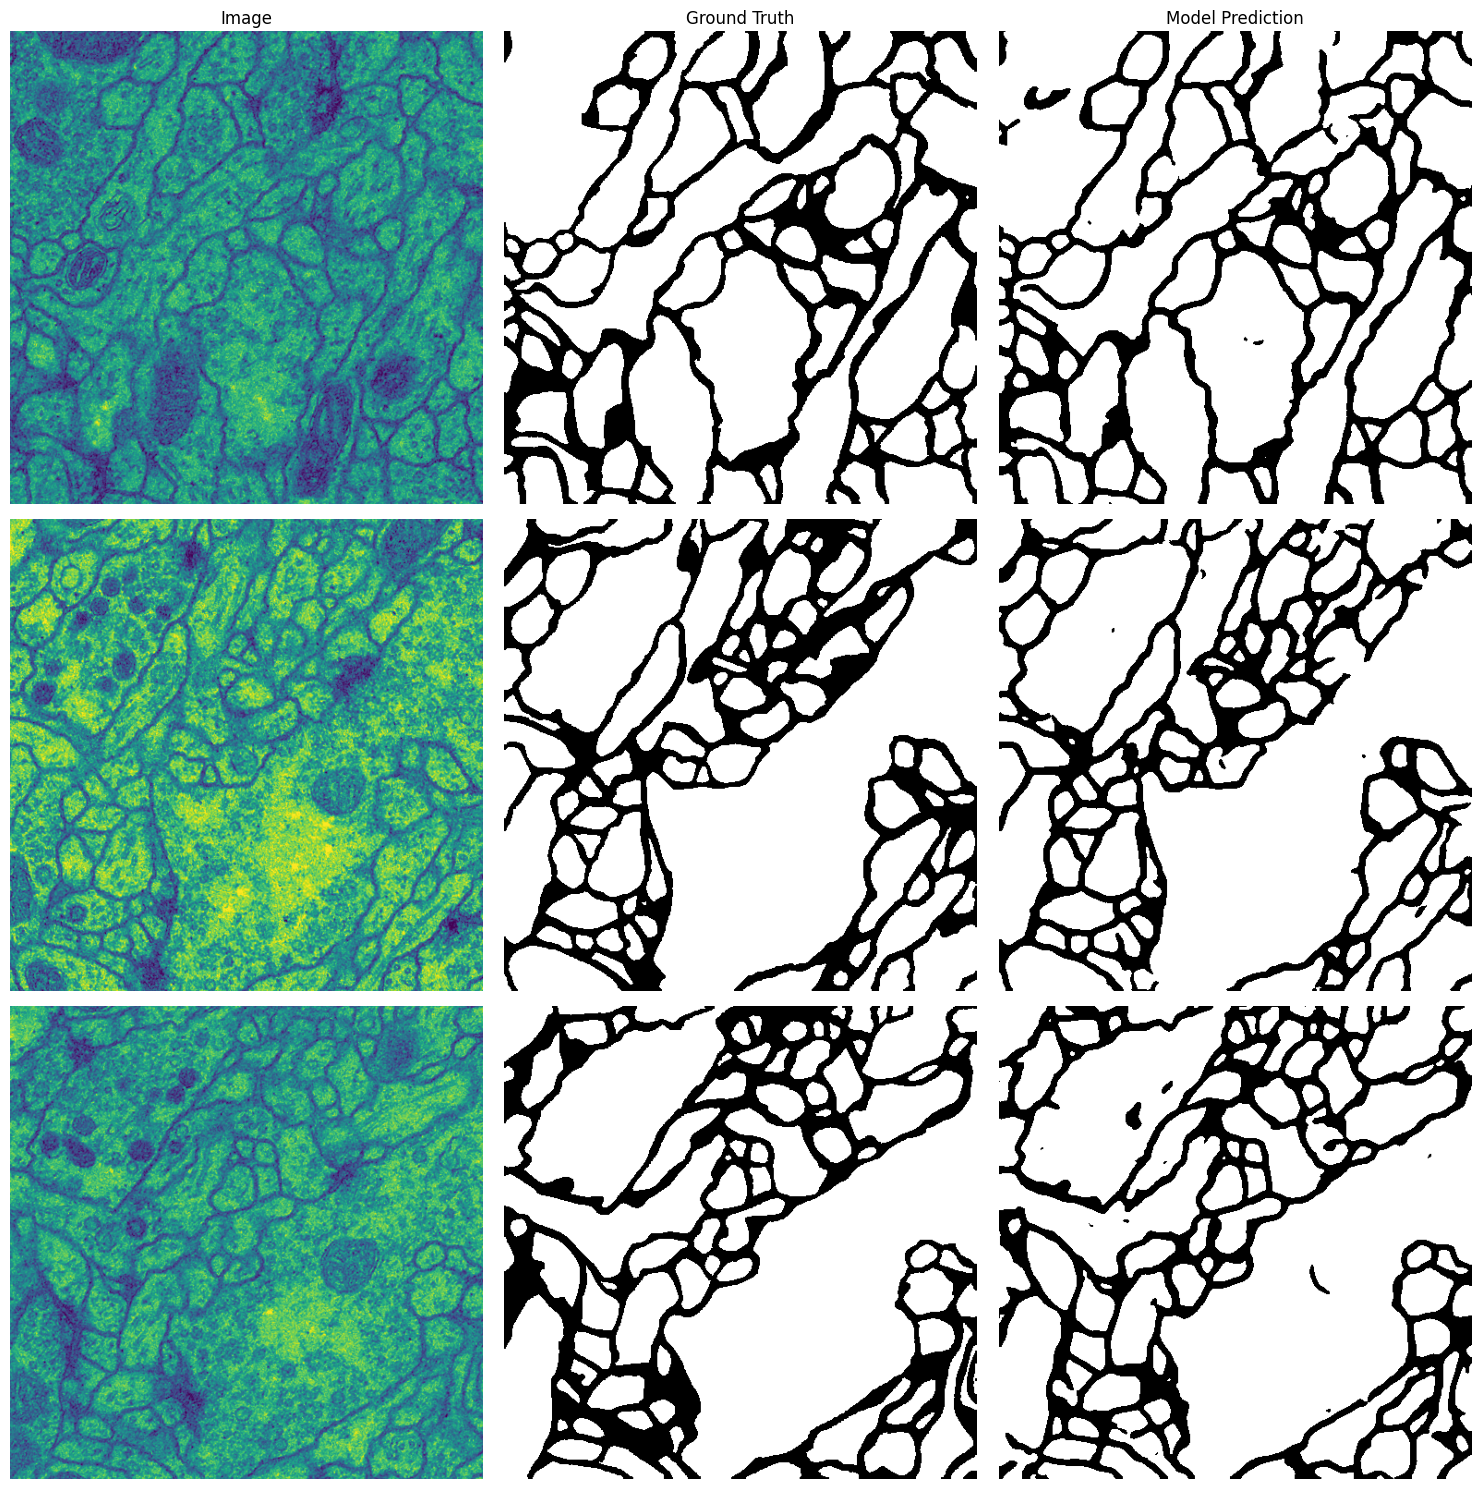

In [17]:
import matplotlib.pyplot as plt
import torch

def plot_predictions(model, dataset, device, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    cols = ['Image', 'Ground Truth', 'Model Prediction']
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=12)

    with torch.no_grad():
        for i in range(num_samples):
            img, mask = dataset[i]

            input_img = img.unsqueeze(0).to(device)
            pred_mask = (torch.sigmoid(model(input_img)) > best_t).float()


            img_np = img.squeeze().cpu().numpy()
            mask_np = mask.squeeze().cpu().numpy()
            pred_np = pred_mask.squeeze().cpu().numpy()

            axes[i, 0].imshow(img_np)
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 2].imshow(pred_np, cmap='gray')

            for ax in axes[i]:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions(model, final_test_ds, device)